Name: Holly Kular\
Date: 03-19-2024\
Email: hkular@ucsd.edu\
decode_L1.m\
Description: wrapper script for decoding analysis on layer 1 of probabilistic RNN

In [1]:
# import these are all needed for fnc
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.optimize import curve_fit
from scipy.io import loadmat

In [2]:
# add decoding functions
from fnc_fit_and_score import fnc_fit_and_score
from fnc_decode_L1 import fnc_decode_L1


In [3]:
# MODIFY HERE - inputs

# What are we decoding?
RNN_params = {}
RNN_params['prob_split'] = '70_30'
RNN_params['afc'] = 2
RNN_params['coh'] = 'lo'
RNN_params['feedback'] = False
RNN_params['thresh'] = [.3,.7]

# Decoding params
D_params = {}
D_params['time_avg'] = False
D_params['t_win'] = [200,-1]
D_params['n_cvs'] = 5
D_params['num_cgs'] = 30
D_params['label'] = 'stim' # 'stim' or 'choice'
D_params['units'] = 'all' # 'all' or 'exc' or 'inh'
D_params['pred'] = 'unexpected' # 'expected' or 'unexpected', trials had stim 0 or 1 dominant

# Timing of task
task_info = {}
task_info['trials'] = 200
task_info['trial_dur'] = 250  # trial duration (timesteps)
task_info['stim_on'] = 80
task_info['stim_dur'] = 50

# Load data
if sys.platform.startswith('linux'):
    data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"
else:
    data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_{RNN_params['prob_split']}_{RNN_params['afc']}afc/feedforward_only/{RNN_params['coh']}_coh"

# Change this if we want a different number of trials and different default stim (0 is the one RNN was trained on)
if D_params['pred'] == 'expected':
    data_file = f"{data_dir}/Trials{task_info['trials']}_0expected.npz"
elif D_params['pred'] == 'unexpected':
    data_file = f"{data_dir}/Trials{task_info['trials']}_1expected.npz"

# Chose the model
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[1]) 
model = loadmat(model_path) # model.keys()


In [ ]:
# Do decoding
acc = fnc_decode_L1(RNN_params, D_params, data_file, task_info, model)
print(f'done decoding')

In [6]:
# Change this
save_plt = True

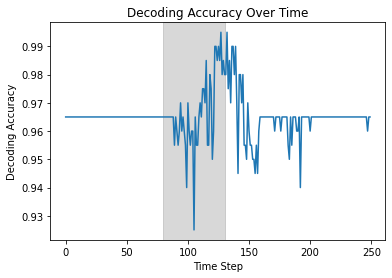

Estimated y-value of the asymptote: 0.9641684023877414


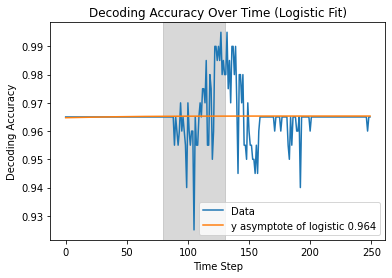

In [7]:
# Make plots based on outputs

# Plot decoding accuracy over time
plt.figure()
plt.plot(range(task_info['trial_dur']), acc)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
if save_plt:
    plt.savefig(f"{data_dir}/decode_T{task_info['trials']}_{D_params['label']}_{D_params['pred']}.png")
plt.show()  


# fit logistic function
def logistic_func(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

popt, _ = curve_fit(logistic_func, range(0, task_info['trial_dur']), acc[0:])

# 'popt' will contain the fitted parameters (a, b, c) of the log function

# Optional: Estimate the y-value of the asymptote (assuming based on parameter b)
asymptote_y = popt[1]
print("Estimated y-value of the asymptote:", asymptote_y)

# Optional: Visualization
plt.plot(range(0, task_info['trial_dur']), acc[0:], label='Data')
plt.plot(range(0, task_info['trial_dur']), logistic_func(range(0, task_info['trial_dur']), *popt), label=f'y asymptote of logistic {round(asymptote_y, 3)}')
plt.axvspan(task_info['stim_on'], task_info['stim_on']+task_info['stim_dur'], color = 'gray', alpha = 0.3)
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy Over Time (Logistic Fit)')
plt.legend()
if save_plt:
    plt.savefig(f"{data_dir}/decode_T{task_info['trials']}_{D_params['label']}_{D_params['pred']}fit.png")
plt.show()
